# Fairness an Explainability with SageMaker Clarify

This is my own code, so I can learn while running the code

- [Link to source](https://sagemaker-examples.readthedocs.io/en/latest/sagemaker-clarify/fairness_and_explainability/fairness_and_explainability_outputs.html)

---

## All the normal conf

In [2]:
import pandas as pd
import numpy as np
import os
import boto3
from datetime import datetime
from sagemaker import get_execution_role, session

In [5]:
sess = session.Session()

region = sess.boto_region_name
print(f'Region: {region}')

role = get_execution_role()
print(f'Role: {role}')

bucket = "test-sagemaker-examples-1357942113492"
prefix = "DEMO_Clarify"

Region: eu-west-1
Role: arn:aws:iam::790592228004:role/service-role/AmazonSageMaker-ExecutionRole-20230510T135961


---

## Download Data

In [6]:
from sagemaker.s3 import S3Downloader

adult_columns = [
    "Age",
    "Workclass",
    "fnlwgt",
    "Education",
    "Education-Num",
    "Marital Status",
    "Occupation",
    "Relationship",
    "Ethnic group",
    "Sex",
    "Capital Gain",
    "Capital Loss",
    "Hours per week",
    "Country",
    "Target",
]

if not os.path.isfile("adult.data"):
    S3Downloader.download(
        s3_uri="s3://{}/{}".format(
            "sagemaker-sample-files", "datasets/tabular/uci_adult/adult.data"
        ),
        local_path="./",
        sagemaker_session=sess,
    )
    print("Data downloaded.")
else:
    print("Data already downloaded.")
    
    
if not os.path.isfile("adult.test"):
    S3Downloader.download(
        s3_uri="s3://{}/{}".format(
            "sagemaker-sample-files", "datasets/tabular/uci_adult/adult.test"
        ),
        local_path="./",
        sagemaker_session=sess,
    )
    print("Test data saved.")
else:
    print("Test data already downloaded.")

Data downloaded.
Test data saved.


---

## Load the data

In [7]:
train_data = pd.read_csv(
    "adult.data", 
    names=adult_columns, 
    sep=r"\s*,\s*", 
    engine="python", 
    na_values="?"
).dropna()

test_data = pd.read_csv(
    "adult.test", 
    names=adult_columns,
    sep=r"\s*,\s*",
    engine="python",
    na_values="?"
).dropna()

train_data.head()

,Age,Workclass,fnlwgt,Education,Education-Num,Marital Status,Occupation,Relationship,Ethnic group,Sex,Capital Gain,Capital Loss,Hours per week,Country,Target
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


---

## Inspecting the Data

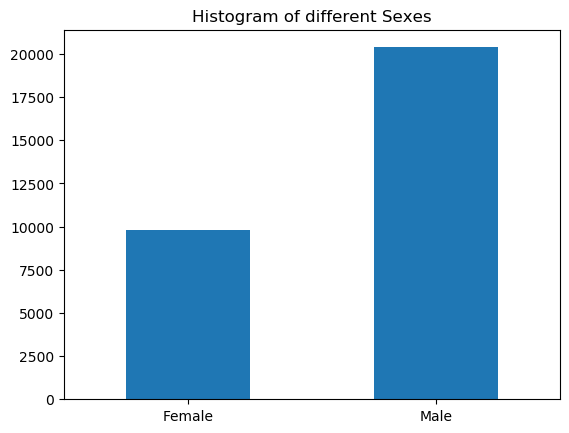

In [8]:
%matplotlib inline
train_data["Sex"].value_counts().sort_values().plot(
    kind="bar",
    title="Histogram of different Sexes",
    rot=0
)

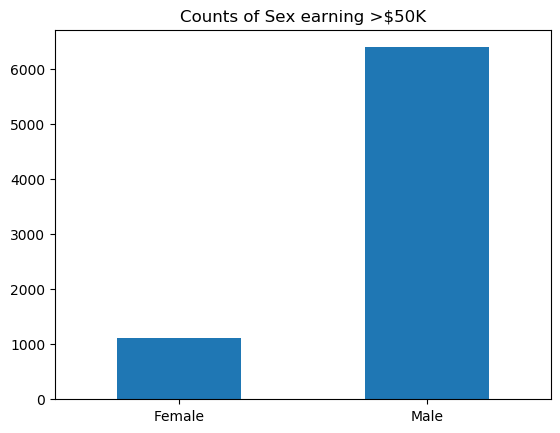

In [12]:
train_data["Sex"].where(
    train_data["Target"] == ">50K").value_counts().sort_values().plot(
    kind="bar",
    title="Counts of Sex earning >$50K",
    rot=0
)

---

## Encode and Upload the Dataset

In [16]:
from sklearn import preprocessing
import sys

def number_encode_features(df):
    result = df.copy()
    encoders = {}
    for column in result.columns:
        if result.dtypes[column] == np.object:
            encoders[column] = preprocessing.LabelEncoder()
            result[column] = encoders[column].fit_transform(result[column].fillna("None"))
    return result, encoders

# Female is encoded as 0, and Male is encoded 1
train_data = pd.concat(
    [train_data["Target"],
     train_data.drop(["Target"], axis=1)
    ], axis=1)

train_data, _ = number_encode_features(train_data)
train_data.to_csv("train_data.csv", index=False, header=False)

test_data, _ = number_encode_features(test_data)
test_features = test_data.drop(["Target"], axis=1)
test_target = test_data["Target"]
test_features.to_csv("test_features.csv", index=False, header=False)
    

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


In [17]:
train_data.head()

,Target,Age,Workclass,fnlwgt,Education,Education-Num,Marital Status,Occupation,Relationship,Ethnic group,Sex,Capital Gain,Capital Loss,Hours per week,Country
0,0,39,5,77516,9,13,4,0,1,4,1,2174,0,40,38
1,0,50,4,83311,9,13,2,3,0,4,1,0,0,13,38
2,0,38,2,215646,11,9,0,5,1,4,1,0,0,40,38
3,0,53,2,234721,1,7,2,5,0,2,1,0,0,40,38
4,0,28,2,338409,9,13,2,9,5,2,0,0,0,40,4


---

## Upload to s3

In [19]:
from sagemaker.s3 import S3Uploader
from sagemaker.inputs import TrainingInput

train_uri = S3Uploader.upload(
    "train_data.csv",
    "s3://{}/{}".format(bucket, prefix))

train_input = TrainingInput(train_uri, content_type="csv")
test_uri = S3Uploader.upload(
    "test_features.csv", 
    "s3://{}/{}".format(bucket, prefix))


---

## Train an XGBoost Model

In [21]:
from sagemaker.image_uris import retrieve
from sagemaker.estimator import Estimator

xgb_img_uri = retrieve(
    "xgboost", 
    region, 
    version="1.5-1")

xgb = Estimator(
    xgb_img_uri,
    role,
    instance_count=1,
    instance_type="ml.m5.xlarge",
    disable_profiler=True,
    sagemaker_session=sess,
)

xgb.set_hyperparameters(
    max_depth=5,
    eta=0.2,
    gamma=4,
    min_child_weight=6,
    subsample=0.8,
    objective="binary:logistic",
    num_round=800,
)

xgb.fit({"train": train_input}, logs=False)

INFO:sagemaker:Creating training-job with name: sagemaker-xgboost-2023-05-24-06-20-34-428



2023-05-24 06:20:35 Starting - Starting the training job.
2023-05-24 06:20:49 Starting - Preparing the instances for training..........
2023-05-24 06:21:43 Downloading - Downloading input data....
2023-05-24 06:22:08 Training - Downloading the training image....
2023-05-24 06:22:34 Training - Training image download completed. Training in progress........
2023-05-24 06:23:14 Uploading - Uploading generated training model.
2023-05-24 06:23:25 Completed - Training job completed


---

## Create Model

In [23]:
model_name = "Demo-Clarify-Model-{}".format(datetime.now().strftime("%d-%m-%Y-%H-%M-%S"))
model = xgb.create_model(name=model_name)
container_def = model.prepare_container_def()
sess.create_model(model_name, role, container_def)

INFO:sagemaker:Creating model with name: Demo-Clarify-Model-24-05-2023-06-27-55


'Demo-Clarify-Model-24-05-2023-06-27-55'

---

## Amazon SageMaker Clarify

In [25]:
from sagemaker import clarify

clarity_processor = clarify.SageMakerClarifyProcessor(
    role=role,
    instance_count=1,
    instance_type="ml.m5.xlarge",
    sagemaker_session=sess
)

INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: 1.0.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.


---

## Detecting Bias

### Writing Dataconfig

DataConfig configurates some basic info for Clarify

In [26]:
bias_report_output_path = "s3://{}/{}/clarify-bias".format(bucket, prefix)

bias_data_config = clarify.DataConfig(
    s3_data_input_path=train_uri,
    s3_output_path=bias_report_output_path,
    label="Target",
    headers=train_data.columns.to_list(),
    dataset_type="text/csv",
)

### Writing ModelConfig

ModelConfig communicates information about trained model.

In [28]:
model_config = clarify.ModelConfig(
    model_name=model_name,
    instance_type="ml.m5.xlarge",
    instance_count=1,
    accept_type="text/csv",
    content_type="text/csv",
)

### Writing ModelPredictedLabelConfig

In [29]:
predictions_config = clarify.ModelPredictedLabelConfig(probability_threshold=0.8)

### Writing BiasConfig

In [31]:
bias_config = clarify.BiasConfig(
    label_values_or_threshold=[1],
    facet_name="Sex",
    facet_values_or_threshold=[0],
    group_name="Age"
)

In [32]:
clarity_processor.run_bias(
    data_config=bias_data_config,
    bias_config=bias_config,
    model_config=model_config,
    model_predicted_label_config=predictions_config,
    pre_training_methods="all",
    post_training_methods="all",
)

INFO:sagemaker.clarify:Analysis Config: {'dataset_type': 'text/csv', 'headers': ['Target', 'Age', 'Workclass', 'fnlwgt', 'Education', 'Education-Num', 'Marital Status', 'Occupation', 'Relationship', 'Ethnic group', 'Sex', 'Capital Gain', 'Capital Loss', 'Hours per week', 'Country'], 'label': 'Target', 'label_values_or_threshold': [1], 'facet': [{'name_or_index': 'Sex', 'value_or_threshold': [0]}], 'group_variable': 'Age', 'methods': {'report': {'name': 'report', 'title': 'Analysis Report'}, 'pre_training_bias': {'methods': 'all'}, 'post_training_bias': {'methods': 'all'}}, 'predictor': {'model_name': 'Demo-Clarify-Model-24-05-2023-06-27-55', 'instance_type': 'ml.m5.xlarge', 'initial_instance_count': 1, 'accept_type': 'text/csv', 'content_type': 'text/csv'}, 'probability_threshold': 0.8}
INFO:sagemaker:Creating processing-job with name Clarify-Bias-2023-05-24-06-55-27-292


..............................2023-05-24 07:00:20,658 logging.conf not found when configuring logging, using default logging configuration.
2023-05-24 07:00:20,659 Starting SageMaker Clarify Processing job
2023-05-24 07:00:20,659 Analysis config path: /opt/ml/processing/input/config/analysis_config.json
2023-05-24 07:00:20,659 Analysis result path: /opt/ml/processing/output
2023-05-24 07:00:20,659 This host is algo-1.
2023-05-24 07:00:20,659 This host is the leader.
2023-05-24 07:00:20,659 Number of hosts in the cluster is 1.
Error retrieving tags. resource_arn: arn:aws:sagemaker:eu-west-1:790592228004:processing-job/clarify-bias-2023-05-24-06-55-27-292
2023-05-24 07:00:20,905 Failed to fetch tags for ProcessingJobArn: arn:aws:sagemaker:eu-west-1:790592228004:processing-job/clarify-bias-2023-05-24-06-55-27-292
2023-05-24 07:00:20,906 Running Python / Pandas based analyzer.
2023-05-24 07:00:20,906 Dataset type: text/csv uri: /opt/ml/processing/input/data
2023-05-24 07:00:20,915 Loading 

In [33]:
bias_report_output_path

's3://test-sagemaker-examples-1357942113492/DEMO_Clarify/clarify-bias'

## Explaining Predictions

In [36]:
explainability_output_path = "s3://{}/{}/clarify-explainability".format(bucket, prefix)
explainability_data_config = clarify.DataConfig(
    s3_data_input_path=train_uri,
    s3_output_path=explainability_output_path,
    label="Target",
    headers=train_data.columns.to_list(),
    dataset_type="text/csv",
)

baseline = [train_data.mean().iloc[1:].values.tolist()]
shap_config = clarify.SHAPConfig(
    baseline=baseline,
    num_samples=1,
    agg_method="mean_abs",
    save_local_shap_values=True
)

In [38]:
clarity_processor.run_explainability(
    data_config=explainability_data_config,
    model_config=model_config,
    explainability_config=shap_config,
)

INFO:sagemaker.clarify:Analysis Config: {'dataset_type': 'text/csv', 'headers': ['Target', 'Age', 'Workclass', 'fnlwgt', 'Education', 'Education-Num', 'Marital Status', 'Occupation', 'Relationship', 'Ethnic group', 'Sex', 'Capital Gain', 'Capital Loss', 'Hours per week', 'Country'], 'label': 'Target', 'predictor': {'model_name': 'Demo-Clarify-Model-24-05-2023-06-27-55', 'instance_type': 'ml.m5.xlarge', 'initial_instance_count': 1, 'accept_type': 'text/csv', 'content_type': 'text/csv'}, 'methods': {'report': {'name': 'report', 'title': 'Analysis Report'}, 'shap': {'use_logit': False, 'save_local_shap_values': True, 'baseline': [[38.437901995888865, 2.1993236522777004, 189793.83393011073, 10.333764339234799, 10.12131158411246, 2.5801339433724553, 5.95985014256349, 1.4183409588223592, 3.6786022147072477, 0.6756846362973278, 1092.0078575691268, 88.37248856176646, 40.93123798156621, 36.382567469000726]], 'num_samples': 1, 'agg_method': 'mean_abs'}}}
INFO:sagemaker:Creating processing-job wi

.............................2023-05-24 07:22:49,148 logging.conf not found when configuring logging, using default logging configuration.
2023-05-24 07:22:49,148 Starting SageMaker Clarify Processing job
2023-05-24 07:22:49,149 Analysis config path: /opt/ml/processing/input/config/analysis_config.json
2023-05-24 07:22:49,149 Analysis result path: /opt/ml/processing/output
2023-05-24 07:22:49,149 This host is algo-1.
2023-05-24 07:22:49,149 This host is the leader.
2023-05-24 07:22:49,149 Number of hosts in the cluster is 1.
Error retrieving tags. resource_arn: arn:aws:sagemaker:eu-west-1:790592228004:processing-job/clarify-explainability-2023-05-24-07-18-03-704
2023-05-24 07:22:49,417 Failed to fetch tags for ProcessingJobArn: arn:aws:sagemaker:eu-west-1:790592228004:processing-job/clarify-explainability-2023-05-24-07-18-03-704
2023-05-24 07:22:49,418 Running Python / Pandas based analyzer.
2023-05-24 07:22:49,419 Dataset type: text/csv uri: /opt/ml/processing/input/data
2023-05-24 07

In [39]:
explainability_output_path

's3://test-sagemaker-examples-1357942113492/DEMO_Clarify/clarify-explainability'

### Analysis of local explanations

Example number: 111 
with model prediction: False

Feature_calues -- Label Target                 0
Age                   21
Workclass              2
fnlwgt            199915
Education             15
Education-Num         10
Marital Status         4
Occupation             7
Relationship           3
Ethnic group           4
Sex                    0
Capital Gain           0
Capital Loss           0
Hours per week        40
Country               38
Name: 120, dtype: int64


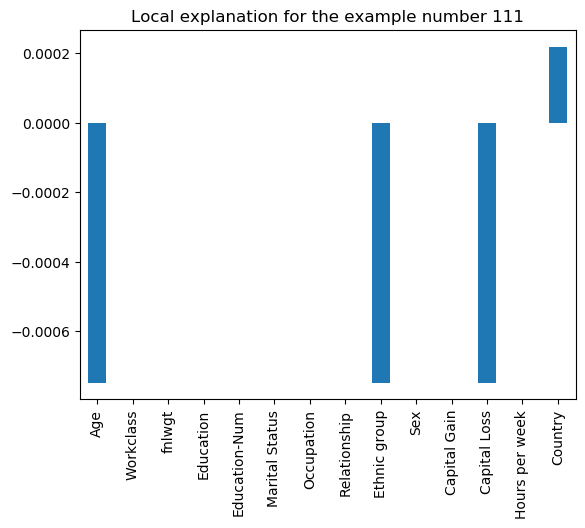

In [42]:
local_explanations_out = pd.read_csv(explainability_output_path + "/explanations_shap/out.csv")

feature_names = [str.replace(c, "_label0", "") for c in local_explanations_out.columns.to_series()]
local_explanations_out.columns = feature_names

selected_example = 111
print(
    "Example number:",
    selected_example,
    "\nwith model prediction:",
    sum(local_explanations_out.iloc[selected_example]) > 0,
)
print("\nFeature_calues -- Label", train_data.iloc[selected_example])
local_explanations_out.iloc[selected_example].plot(
    kind="bar",
    title="Local explanation for the example number " + str(selected_example),
    rot=90
)

In [44]:
sess.delete_model(model_name)

INFO:sagemaker:Deleting model with name: Demo-Clarify-Model-24-05-2023-06-27-55
